# PDEformer-1: 面向一维 PDE 的基础模型

## 概述

### 问题描述

偏微分方程（PDEs）的变化与一系列广泛的物理现象和工程应用有关，如机翼设计、电磁场模拟、应力分析等。
这些实际的工程应用均需要多次调用求解 PDE；尽管传统的 PDE 求解方法通常表现出较高的准确性，但往往需要大量的计算资源和时间，且难以针对所有 PDE 形式设计统一的求解器。
近年来，神经算子（Neural Operator）方法使用神经网络学习大量 PDE 解的数据来近似 PDE 的解算子，极大地提高了 PDE 正问题的求解速度，同时训练得到的神经网络模型也可以作为可微分的 surrogate model 来处理反问题。
然而，目前的神经算子方法仍难以对新的 PDE 形式泛化，针对新 PDE 进行训练往往也会遇到训练代价高和数据获取难得问题。

针对以上问题，我们提出了 PDEformer 模型，这是一种可以直接输入任意 PDE 形式的神经算子模型。
经过在大规模的一维 PDE 数据上进行训练，PDEformer 模型已经能够快速准确得求解任意形式的一维 PDE 正问题，且在训练数据分布内 zero-shot 预测精度高于任一种针对某一种方程专门进行训练的专家模型（如 FNO、DeepONet）。
PDEformer 针对方程系数分布内的新问题无需重新训练，对于方程系数分布外的情形则可以通过少量数据 finetune 的 few-shot learning 快速泛化到下游任务。
与此同时，我们还可以直接将 PDEformer 运用到反问题的求解中。
通过进一步增大数据集规模，PDEformer 有望成为解决各种 PDE 问题的基础模型，推动科学研究和工程应用的发展。

## 技术路径

我们考虑定义在 $(t,x)\in[0,1]\times[-1,1]$ 上，具有周期性边界条件的一维时间依赖偏微分方程（PDEs），其一般形式为

$$ \mathcal{F}(u_1,u_2,\dots,c_1,c_2,\dots,s_1(x),s_2(x),\dots)=0,$$

其中 $c_1,c_2,\dots \in \mathbb{R}$ 是实值系数，$s_1(x),s_2(x)\dots$ 是标量函数（在方程中可作为初始条件、系数场等），$u_1,u_2,\dots$ 为待求解的物理场的各个分量。
在这里，我们假设算子 $\mathcal{F}$ 具有符号表达式，其中可能涉及微分和代数运算。
PDEformer 的目标是构建一个方程解的 surrogate model，形式为 $(\mathcal{F},c_1,c_2,\dots,s_1(x),s_2(x),\dots)\mapsto (u_1,u_2,\dots)$，
它将 PDE 的符号形式 $\mathcal{F}$ 及其中涉及的数值信息 $c_1,c_2,\dots,s_1(x),s_2(x),\dots$ 作为输入，输出相应方程的预测解 $u_1,u_2,\dots$。
以具有周期边界条件的对流方程（单分量）$u_t+cu_x=0$，$u(0,x)=g(x)$ 为例：

![](images/PDEformerV2Arch.png)

### 构建 PDE 计算图

首先，我们将$\mathcal{F}$（关于待求解 PDE 形式的符号信息）表示为计算图。
在这个计算图中，一个节点可以代表一个未知场分量（用 `UF` 表示）、标量系数（`SC`）、系数场（`CF`）、初始条件（`IC`），以及微分或代数运算，一条有向边则用于指定参与运算的操作数。
这构成了一个具有异构节点和同构边的有向无环图（DAG）。

然后，为了体现 PDE 中涉及的数值信息，我们为图中的每个节点赋予一个 $d_e$ 维的输入特征。
对于一个标量系数 $c$，我们将它的数值输入一个标量编码器（scalar encoder），将编码器给出的 $d_e$ 维的输出作为相应 `SC` 节点的输入特征。
考虑到标量函数 $s(x)$ 包含的信息相对更为丰富，我们为每个这样的标量函数引入 $N$ 个新的“分支”节点（类型为 $\mathtt{b}_1,\mathtt{b}_2,\dots,\mathtt{b}_N$），用这 $N$ 个节点的输入特征表示 $s(x)$ 所包含的数值信息。
具体地说，我们使用一个函数编码器（function encoder），其输入为一系列散点 $\{(x_i,s(x_i))\}$（散点的位置与分布可任意选取），而输出的 $d_eN$ 维向量被用于给出 $N$ 个分支节点的输入特征。
图中的这些分支节点与 $s(x)$ 所对应的 `IC` 或 `CF` 顶点之间有相连的边。
所有剩余节点的输入特征都设为零（为简化编程实现，实际上是标量编码器接收零输入时的对应输出）。

此外，我们还为每个待求解的场分量引入了 $L$ 个额外节点（类型为 $\mathtt{m}_1,\mathtt{m}_2,\dots,\mathtt{m}_L$），并将它们与相应的 `UF` 节点连接起来。
后续使用 graph Transformer 处理图数据时，关于这一场分量的预测解的信息将被汇总到这些新节点所对应的嵌入向量当中。

### 编码图数据

上一步获得的图数据包含了 PDE 涉及的符号与数值信息。
我们将融合图数据中这些信息，并为每个待求解的场分量 $u_j$ 生成一个表征解的隐编码

$$\pmb{\mu}_j = [{\mu}^1_j, \dots, {\mu}^L_j]^{\mathrm{T}} \in {\mathbb{R}}^{L \times d_e}.$$

该融合过程使用了 graph Transformer，其是一类功能强大的、基于 Transformer 的图神经网络，擅长捕捉和表达复杂的图结构信息。
在具体实现时，我们采用了 Graphormer 架构，并针对 PDE 编码这一场景做了一些适配调整。
Graph Transformer 输出层中类型为 $\mathtt{m}_\ell$（且与 $u_j$ 对应）节点对应的嵌入向量记为 $\mu_j^\ell\in\mathbb{R}^{d_e}$，它将在下一步中参与“调制”INR 中的第 $\ell$ 个隐藏层，以生成最终的预测解。

### 解码获得 PDE 的预测解

我们采用 INR（隐式神经表示）方式来表示方程解的各个分量。
这一网络以时空坐标 $(t,x)$ 作为输入，并根据隐编码 $\pmb{\mu}_j$ 来预测出相应的方程解分量在该坐标点的取值 $\hat u_j(t,x)$。
通过这种方式给出的预测不依赖于特定的离散网格。
在具体实现时，我们选用了 Poly-INR 架构，并做了相应的适配（见下图）。
Poly-INR 的隐层数目为 $L$，其中第 $\ell$ 个隐层的激活值将被 $\mu_j^\ell$“调制”。
注意 PDE 中的所有的分量共享同一套 INR 的参数，它们仅仅是对应的隐编码 $\pmb{\mu}_j$ 有所不同。

![](images/HyperPolyINR2.png)


### 推理示例

下面的示例代码展示了如何使用 PDEformer 预测给定 PDE 的解。运行前需要先下载经过预训练的 PDEformer 权重，并将 `configs/inference/pdeformer-L.yaml` 中 `model/load_ckpt` 参数的值改为相应的权重文件路径。

In [1]:
import numpy as np
from mindspore import context
from mindspore import dtype as mstype
from src import load_config, get_model, PDENodesCollector, inference_pde
from src.utils.visual import plot_infer_result
from ipywidgets import interact, FloatSlider
from src import generate_plot

# 基本设定
context.set_context(mode=context.PYNATIVE_MODE, device_target="CPU")
config, _ = load_config("configs/inference/pdeformer-L.yaml")
model = get_model(config, compute_type=mstype.float32)

#### 求解无粘性 Burgers 方程

- PDE 形式: $u_{t} + (\frac{1}{2}u^2)_x = 0$

- 初始条件： $u(0,x) = -\sin(\pi x)$

- 边界条件：周期边界条件

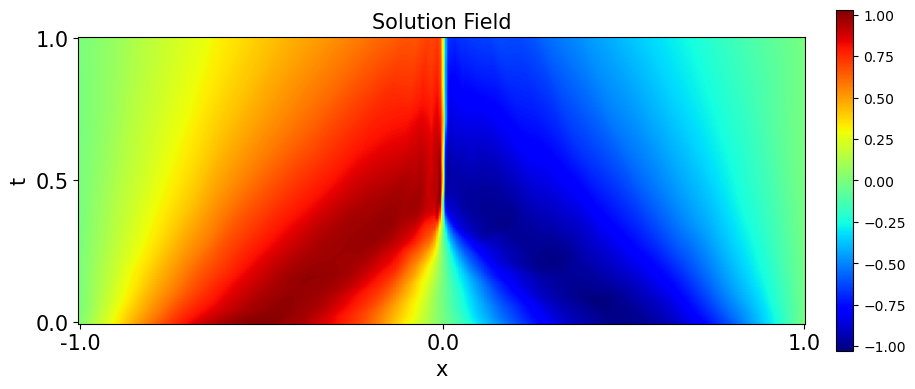

In [2]:
# 定义时空坐标点
x_coord = np.linspace(-1, 1, 257)[:-1]
t_coord = np.linspace(0, 1, 101)

# 指定待求解的 PDE
pde = PDENodesCollector()
u = pde.new_uf()
pde.set_ic(u, x_coord, -np.sin(np.pi * x_coord))
pde.sum_eq0(pde.dt(u), pde.dx(0.5 * pde.square(u)))

# 使用 PDEformer 预测解并绘图
pde_dag = pde.gen_dag(config)
u_pred = inference_pde(model, pde_dag, t_coord, x_coord)
plot_infer_result(u_pred, x_coord, t_coord)

#### 求解 Advection 方程

- PDE 形式: $u_{t} + \beta u_{x} = 0, \beta = 0.9$

- 初始条件： $u(0,x) = \sin(5\pi x)-\sin(2 \pi x)$

- 边界条件：周期边界条件

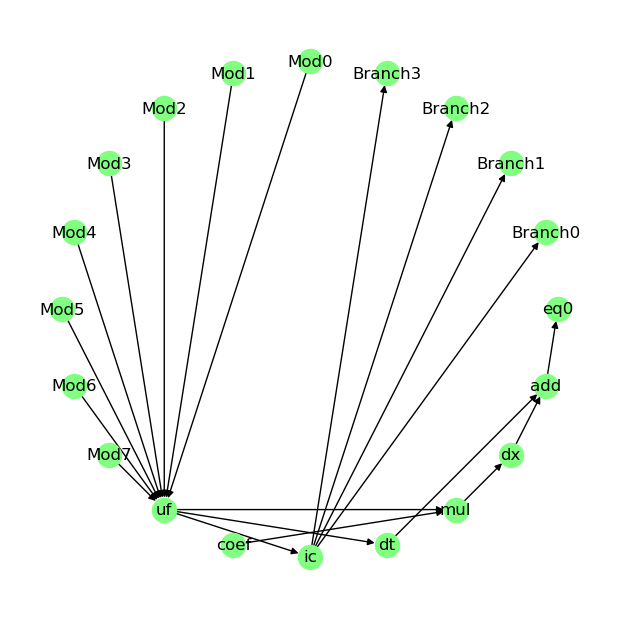

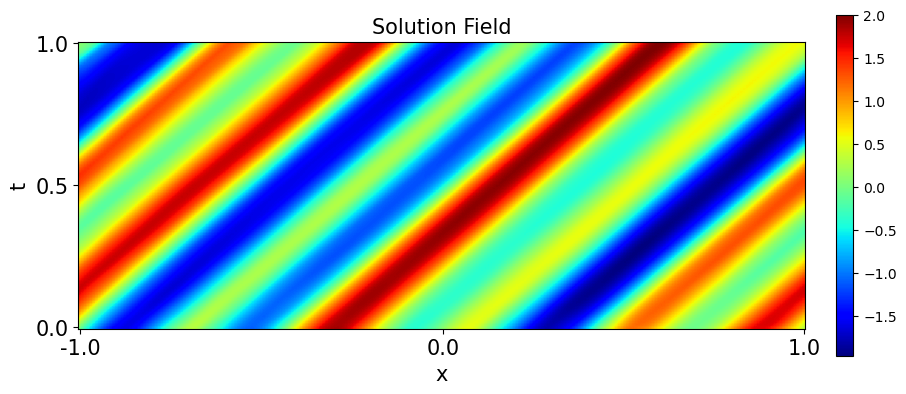

In [3]:
# 指定待求解的 PDE
pde = PDENodesCollector()
u = pde.new_uf()
beta = pde.new_coef(0.9)
pde.set_ic(u, x_coord, np.sin(5 * np.pi * x_coord) - np.sin(2 * np.pi * x_coord))
pde.sum_eq0(pde.dt(u), pde.dx(beta * u))

# 使用 PDEformer 预测解并绘图
pde_dag = pde.gen_dag(config)
pde_dag.plot()  # 绘制 PDE 的计算图
u_pred = inference_pde(model, pde_dag, t_coord, x_coord)
plot_infer_result(u_pred, x_coord, t_coord)

#### 求解非周期边界有粘性 Burgers 方程

- PDE 形式: $u_{t} + (\frac{1}{2}u^2 - \kappa u_x)_x = 0$

- 初始条件：$u(0,x) = \cos(8x) + x$

- 边界条件：左侧齐次 Dirichlet（$u|_{x=-1}=0$），右侧非齐次 Neumann（$u_x|_{x=1}=-0.6$）

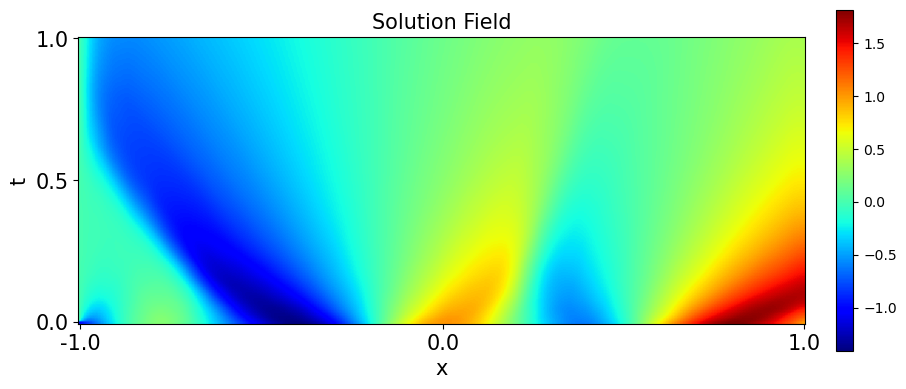

In [4]:
# 指定待求解的 PDE
pde = PDENodesCollector()
u = pde.new_uf()
pde.set_ic(u, x_coord, np.cos(8 * x_coord) + x_coord)
dx_u = pde.dx(u)
pde.sum_eq0(pde.dt(u), pde.dx(0.5 * pde.square(u) - 0.02 * dx_u))
pde.set_bv_l(u, 0)
pde.set_bv_r(dx_u, -0.6)

# 使用 PDEformer 预测解并绘图
pde_dag = pde.gen_dag(config)
u_pred = inference_pde(model, pde_dag, t_coord, x_coord)
plot_infer_result(u_pred, x_coord, t_coord)

#### 一般方程形式的求解

- PDE 形式与初始条件

\begin{align}
u_t + f_0(u) + s + (f_1(u) - \kappa u_x)_x &= 0, \quad (t,x) \in [0,1] \times [-1,1], \\
f_i(u) &= c_{i1}u+c_{i2}u^2+c_{i3}u^3, \quad(i=0,1), \\
u(0,x) &= g(x), \quad x \in [-1,1]
\end{align}

In [5]:
g = -np.sin(2 * np.pi * x_coord)

def interactive_plot(c_01, c_02, c_03, c_11, c_12, c_13, kappa, source):
    generate_plot(model, config, g, x_coord, t_coord,
                  [c_01, c_02, c_03, c_11, c_12, c_13], kappa, source)

interact(interactive_plot,
         c_01=FloatSlider(value=0, min=-3, max=3, step=0.01),
         c_02=FloatSlider(value=0, min=-3, max=3, step=0.01),
         c_03=FloatSlider(value=0, min=-3, max=3, step=0.01),
         c_11=FloatSlider(value=0, min=-3, max=3, step=0.01),
         c_12=FloatSlider(value=0.5, min=-3, max=3, step=0.01),
         c_13=FloatSlider(value=0, min=-3, max=3, step=0.01),
         kappa=FloatSlider(value=0.0, min=0, max=1, step=0.001),
         source=FloatSlider(value=0, min=-3, max=3, step=0.01))

interactive(children=(FloatSlider(value=0.0, description='c_01', max=3.0, min=-3.0, step=0.01), FloatSlider(va…

<function __main__.interactive_plot(c_01, c_02, c_03, c_11, c_12, c_13, kappa, source)>

#### 求解非周期边界波方程

- PDE 形式: $u_{tt}-c(x)^2u_{xx}=0$

- 速度场：$c(x)=1.1-e^{-8x^2}$

- 初始条件：$u(0,x) = \sin(\pi x)\cos(8x)$，$u_t(0,x)=0$

- 边界条件：左侧非齐次 Robin $(-0.6u+0.8u_x)|_{x=-1}=0.1$，右侧 Mur $(u_t+c(1)u_x)|_{x=1}=0$

- 注意：请加载在wave数据上finetune的checkpoint文件

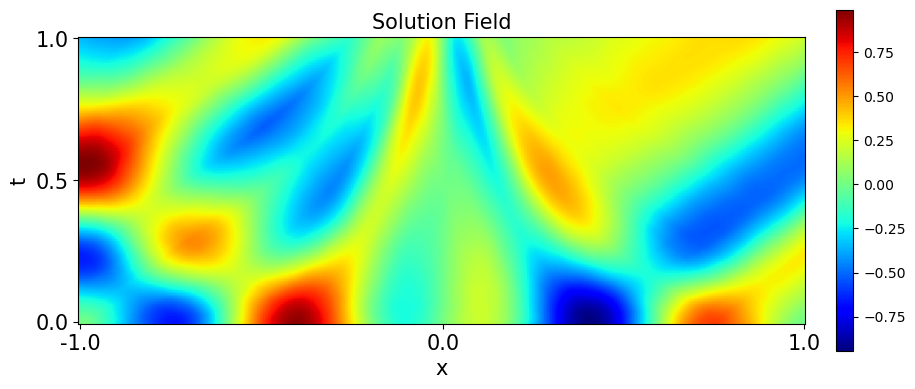

In [6]:
pde = PDENodesCollector()
u = pde.new_uf()

# 初值
pde.set_ic(u, x_coord, np.sin(np.pi * x_coord) * np.cos(8 * x_coord))
pde.set_ic(u.dt, x_coord, 0 * x_coord)

# 速度场与边值
c_arr = 1.1 - np.exp(-8 * x_coord**2)
pde.set_bv_l(0.8 * u.dx + (-0.6) * u, 0.1)
pde.set_bv_r(u.dt + c_arr[-1] * u.dx, 0)

# 主体方程
c2 = pde.new_coef_field(x_coord, c_arr**2)
pde.sum_eq0(u.dt.dt, -(c2 * u.dx.dx))

# 使用 PDEformer 预测解并绘图
pde_dag = pde.gen_dag(config)
u_pred = inference_pde(model, pde_dag, t_coord, x_coord)
plot_infer_result(u_pred, x_coord, t_coord)